### In this final assignment will try to explore image colorization using autoencoders

We get started by importing a dataset. We found a dataset for colouring on kaggle that has already prepared train and test split. It contains a folder with coloured images and folder with corresponding images in greyscale.

In [1]:
import kagglehub

path = kagglehub.dataset_download("aayush9753/image-colorization-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/aayush9753/image-colorization-dataset/versions/1


Once we have our data imported, we can get started with importing libs and getting our dataset prepared for model training.

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_folder = os.path.join(path, "data")

train_black_path = os.path.join(data_folder, "train_black")
train_color_path = os.path.join(data_folder, "train_color")
test_black_path = os.path.join(data_folder, "test_black")
test_color_path = os.path.join(data_folder, "test_color")

train_black_files = os.listdir(train_black_path)
test_black_files = os.listdir(test_black_path)

print(f"Number of training images: {len(train_black_files)}")
print(f"Number of test images: {len(test_black_files)}")

Number of training images: 5000
Number of test images: 739


As we can see we have 5000 training images and 739 test images.

In [4]:
def load_images(image_folder, target_size=(160, 160), grayscale=False):
    images = []
    # we are sorting the files so that the coloured images and black and white images match
    for file in sorted(os.listdir(image_folder)):
        if grayscale:
            # read files as grayscale images
            img = cv2.imread(os.path.join(image_folder, file), cv2.IMREAD_GRAYSCALE)
            # resize the image to the target size
            img = cv2.resize(img, target_size)
            # our model expects 3 channels, so we need to convert the grayscale image to 3 channels
            # we will do this by duplicating the grayscale channel 3 times
            img = np.stack([img] * 3, axis=-1)
        else:
            # read files as color images
            img = cv2.imread(os.path.join(image_folder, file), cv2.IMREAD_COLOR)
            img = cv2.resize(img, target_size)
            # by default cv library reads images in BGR format and we need to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images.append(img)

    return np.array(images)

# the cv library returns pixel values in the range of 0-255
# for our model we need to scale the pixel values to the range of 0-1
X_train = load_images(train_black_path, grayscale=True) / 255.0
Y_train = load_images(train_color_path) / 255.0

X_test = load_images(test_black_path, grayscale=True) / 255.0
Y_test = load_images(test_color_path) / 255.0

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")


X_train shape: (5000, 160, 160, 3), Y_train shape: (5000, 160, 160, 3)
X_test shape: (739, 160, 160, 3), Y_test shape: (739, 160, 160, 3)


In [5]:
# basic self attention-like block
# we use this block to apply attention during decoding
# this will help the model to focus on important parts of the image
# while try to reconstruct the image
def attention_block(x):
    n_channels = x.shape[-1]

    # we run 1x1 convolution on the input tensor to get the attention mask
    # because our kernel size is 1, we are essentially running a dense layer
    # and getting score for each pixel from 0 to 1 (sigmoid activation)
    # that will tell us how much attention we should give to each pixel
    attention = layers.Conv2D(n_channels, 1, padding='same', activation='sigmoid')(x)

    # we multiply the attention mask with the input tensor
    # basically decreasing the importance of pixels that are not important
    return layers.multiply([x, attention])

# we define the encoder block that will downsample the image and try to transform it into latent space
# each block has 2 convolutional layers with leaky relu activation
# first convolution has rather big kernel to capture more spatial information
# second convolution has smaller kernel to refine the features
# we also decrease the width and height of the image by using strides=2
# we use leaky relu instead of relu to fight the vanishing gradient problem
# alpha in leaky relu tells us how much negative values should be preserved
# we found it empirically that 0.2 works well
# we use padding to keep the width and height of the image same (ofc except when using bigger stride)
def encoder_block(n_channels, kernel_size, use_batch_norm=True):
    block = tf.keras.Sequential([
        layers.Conv2D(n_channels, (5,5), padding='same', strides=2),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(n_channels, kernel_size, padding='same', strides=1),
        layers.LeakyReLU(alpha=0.2)
    ])

    if use_batch_norm:
        block.add(layers.BatchNormalization())

    return block

# in our decoder block we will upsample the image and try to reconstruct it from the latent space
# we use transposed convolution to upsample the image (increase width and height)
# the idea behind doubling number of channels during upsampling is to give model capacity for reconstruction
# then we apply convolution to refine the features
def decoder_block(n_channels, kernel_size, use_dropout=False):
    block = tf.keras.Sequential([
        layers.Conv2DTranspose(n_channels*2, kernel_size, padding='same', strides=2),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(n_channels, kernel_size, padding='same', strides=1),
        layers.LeakyReLU(alpha=0.2)
    ])

    if use_dropout:
        block.add(layers.Dropout(0.2))

    return block

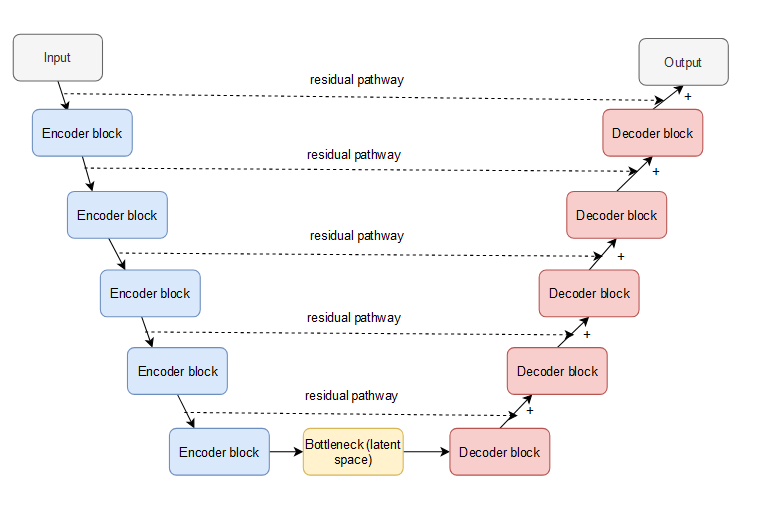

In [2]:
from IPython.display import Image

# image presenting abstract overview of the model architecture
Image("./model_arch.png")

In [6]:
# we define our autoencoder model architecture
# we use 5 encoder blocks and 5 decoder blocks
# we base this architecture on the U-Net architecture
#(image above presents our highly abstracted architecture and why it is called U-Net -> basically it is U-shaped)
# in this architecture we have residual connections between encoder and decoder blocks
# this helps with gradient flow and allows the model to learn better
def model():
    inputs = layers.Input(shape=[160,160,3])

    encode1 = encoder_block(64, (3,3), False)(inputs)
    encode2 = encoder_block(128, (3,3), False)(encode1)
    encode3 = encoder_block(256, (3,3), True)(encode2)
    encode4 = encoder_block(512, (3,3), True)(encode3)
    encode5 = encoder_block(512, (3,3), True)(encode4)

    # once we reach our latent space (bottle neck of autoencoder)
    # we try to transform this data a little bit more
    # we use dilation rate to increase the receptive field of the network

    # at the bottleneck of autoencoder (once we reach latent space), we use dilated convolutions to capture wider spatial context
    # dilation creates gaps in the convolution kernel, allowing each neuron to see a larger area of the input without increasing parameters.
    # for example dilation rates of 2 mean
    # that kernel looks at every other pixel in the tensor
    # basiclly increasing the receptive field while maintaining resolution

    bottle_neck = layers.Conv2D(512, 3, padding='same', dilation_rate=2)(encode5)
    bottle_neck = layers.LeakyReLU(alpha=0.2)(bottle_neck)
    bottle_neck = layers.Conv2D(512, 3, padding='same', dilation_rate=4)(bottle_neck)
    bottle_neck = layers.LeakyReLU(alpha=0.2)(bottle_neck)

    # For each layer of decoding we first get the decoded output
    # apply self attention block to focus on important parts of the image
    # and then concatenate the output with the output of the encoder block on the same level
    # this serves as a residual connection and allows better gradient flow
    decode1 = decoder_block(512, (3, 3), True)(bottle_neck)
    decode1 = attention_block(decode1)
    decode1 = layers.concatenate([decode1, encode4])

    decode2 = decoder_block(256, (3, 3), False)(decode1)
    decode2 = attention_block(decode2)
    decode2 = layers.concatenate([decode2, encode3])

    decode3 = decoder_block(128, (3, 3), False)(decode2)
    decode3 = attention_block(decode3)
    decode3 = layers.concatenate([decode3, encode2])

    decode4 = decoder_block(64, (3, 3), False)(decode3)
    decode4 = attention_block(decode4)
    decode4 = layers.concatenate([decode4, encode1])

    decode5 = decoder_block(32, (3, 3), False)(decode4)
    decode5 = layers.concatenate([decode5, inputs])

    # once we almost reconstructed the image to original size
    # we apply one more convolution to add model capacity
    x = layers.Conv2D(32, (3, 3), padding='same')(decode5)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # in the last layer we use sigmoid activation function to get pixel values in the range of 0-1
    output = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=output)


In [7]:
# build model
autoencoder = model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
# now we will prepared also validation set as the the dataset provided only train and test splits
# first lets ensure that all the tensors have the same precision
X_train = tf.cast(X_train, tf.float32)
Y_train = tf.cast(Y_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
Y_test = tf.cast(Y_test, tf.float32)

# we decided to use 10% of the training data for validation
validation_split = 0.1

val_size = int(len(X_train) * validation_split)
train_size = len(X_train) - val_size

# first we can shuffle the full dataset (with seed for reproduction reasons)
full_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
full_dataset = full_dataset.shuffle(len(X_train), seed=42)

batch_size = 32

# then we split dataset into test and val set
train_dataset = full_dataset.take(train_size).batch(batch_size)
val_dataset = full_dataset.skip(train_size).batch(batch_size)

# then we repeat train dataset indefinetely so that we can reuse it across epochs, also we want to shuffle it
train_dataset = train_dataset.shuffle(1000).repeat()

# at the end we calculate the number of steps per epoch
steps_per_epoch = train_size // batch_size


In [9]:
# one of the biggest issues that we saw when experimenting with the autoencoders is that
# if the loss was simple mean absolute error, the model would try to learn to color using safe colors
# like brownish colors
# we tried to combat this by creating a custom loss function
# that would not only penalize the model for not getting the colors right
# but also for not getting the saturation right
# meaning that if the all colors were very sepia-like, desaturated, the model would be penalized
# of course most of the loss is still based on the mean absolute error between values of the pixels
# this helped a little bit with the colorization quality
def colorization_loss(y_true, y_pred):
    # we use epsilon to avoid log(0) and division by zero in edge cases
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.clip_by_value(y_true, epsilon, 1.0 - epsilon)

    # Main MAE loss for overall color accuracy
    mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Light desaturation penalty
    # we transform the images to hsv space
    # hsv space is a color space with hue, saturation and value
    # hue is the color, saturation is the intensity of the color and value is the brightness
    y_true_hsv = tf.image.rgb_to_hsv(y_true)
    y_pred_hsv = tf.image.rgb_to_hsv(y_pred)

    # also in form of MAE
    saturation_loss = tf.reduce_mean(tf.abs(y_true_hsv[..., 1] - y_pred_hsv[..., 1]))

    # Combine with more weight on MAE
    return 0.8 * mae_loss + 0.2 * saturation_loss

# compiling with custom loss
# we decided to use safe pick with optimizer being Adam with learning rate of 0.0002
# for tracking metrics we use mean absolute error
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss=colorization_loss,
    metrics=['mae']
)



In [10]:
# for leaning rate scheduling we use reduce on plateau scheduler that decreases lr by half
# we also do early stopping with patience of 20 epochs in case the model stops learning
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
]

# looking at the loss graphs we decided to train for 100 epochs
history = autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 225ms/step - loss: 0.1775 - mae: 0.1665 - val_loss: 0.1283 - val_mae: 0.1107 - learning_rate: 2.0000e-04
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.1057 - mae: 0.0843 - val_loss: 0.1003 - val_mae: 0.0780 - learning_rate: 2.0000e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0995 - mae: 0.0764 - val_loss: 0.0950 - val_mae: 0.0713 - learning_rate: 2.0000e-04
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0962 - mae: 0.0728 - val_loss: 0.0931 - val_mae: 0.0702 - learning_rate: 2.0000e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0925 - mae: 0.0688 - val_loss: 0.0913 - val_mae: 0.0666 - learning_rate: 2.0000e-04
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0915 - mae: 0.0667 - val_loss: 0.0874 - val_mae: 0.0635 - learning_rate: 2.0000e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0887 - mae: 0.0636 - val_loss: 0.0885 - val_ma

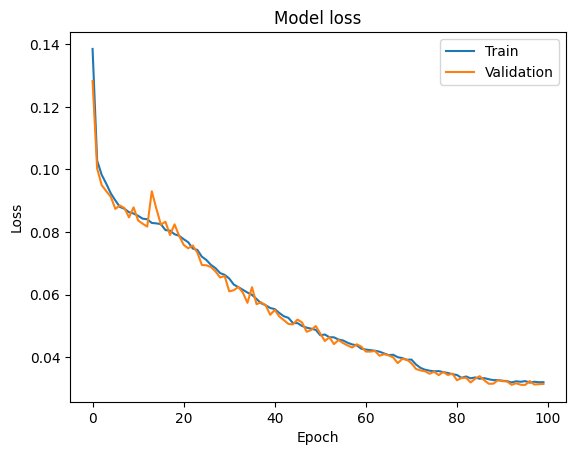

In [11]:
# let's plot the train and validation loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

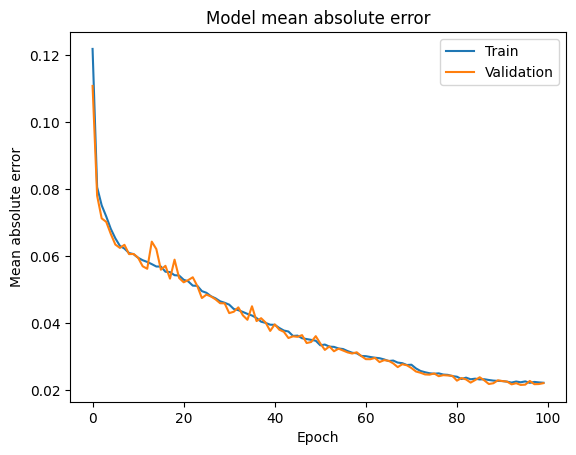

In [12]:
# let's plot the train and validation metrics graph
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mean absolute error')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

As we can see we achieved nice training and validation curve. We don't see signs of overfitting. Both losses steadily decrease until the look like they are converging near the 100 epoch. Same with the metric (MAE) value. Let's try to evaluate our model on the test set, to see if the model generalizes well.

In [13]:
# we will now evaluate the model on the test set
autoencoder.evaluate(X_test, Y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.0822 - mae: 0.0549


[0.0832730159163475, 0.0554676353931427]

It looks that even though the validation and training losses were super close, the test loss is a little bit higher. It might indicate that the distribution of images in these 2 splits in kaggle dataset might be a little bit different

Let's try to visualize the greyscale image, the original image and the colorized image for a few images from the test set.

In [14]:
# now we will build the function to visualize the original colored image, its grayscale version and the reconstructed version
def plot_images(model, greyscale_images, color_images, start_index):
    greyscale_sample = greyscale_images[start_index:start_index + 5]
    color_sample = color_images[start_index:start_index + 5]
    reconstructed_sample = model.predict(greyscale_sample)

    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(color_sample[i])
        plt.axis('off')
        plt.title("Original Image")

        plt.subplot(3, 5, i + 6)
        plt.imshow(greyscale_sample[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Grayscale Image")

        plt.subplot(3, 5, i + 11)
        plt.imshow(reconstructed_sample[i])
        plt.axis('off')
        plt.title("Reconstructed Image")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


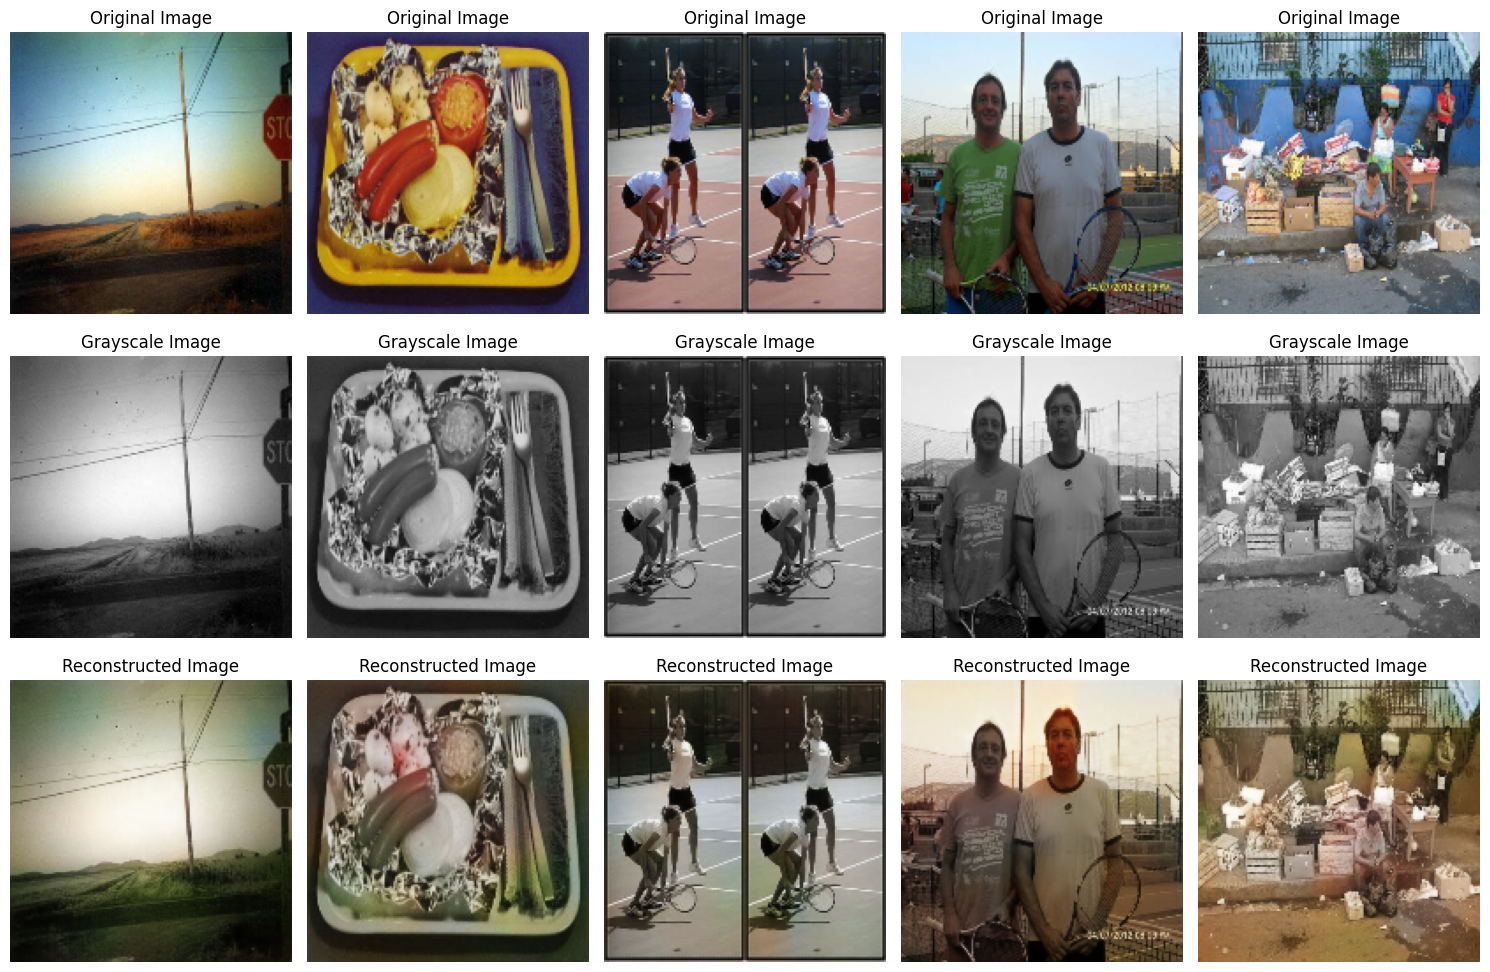

In [15]:
plot_images(autoencoder, X_test, Y_test, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


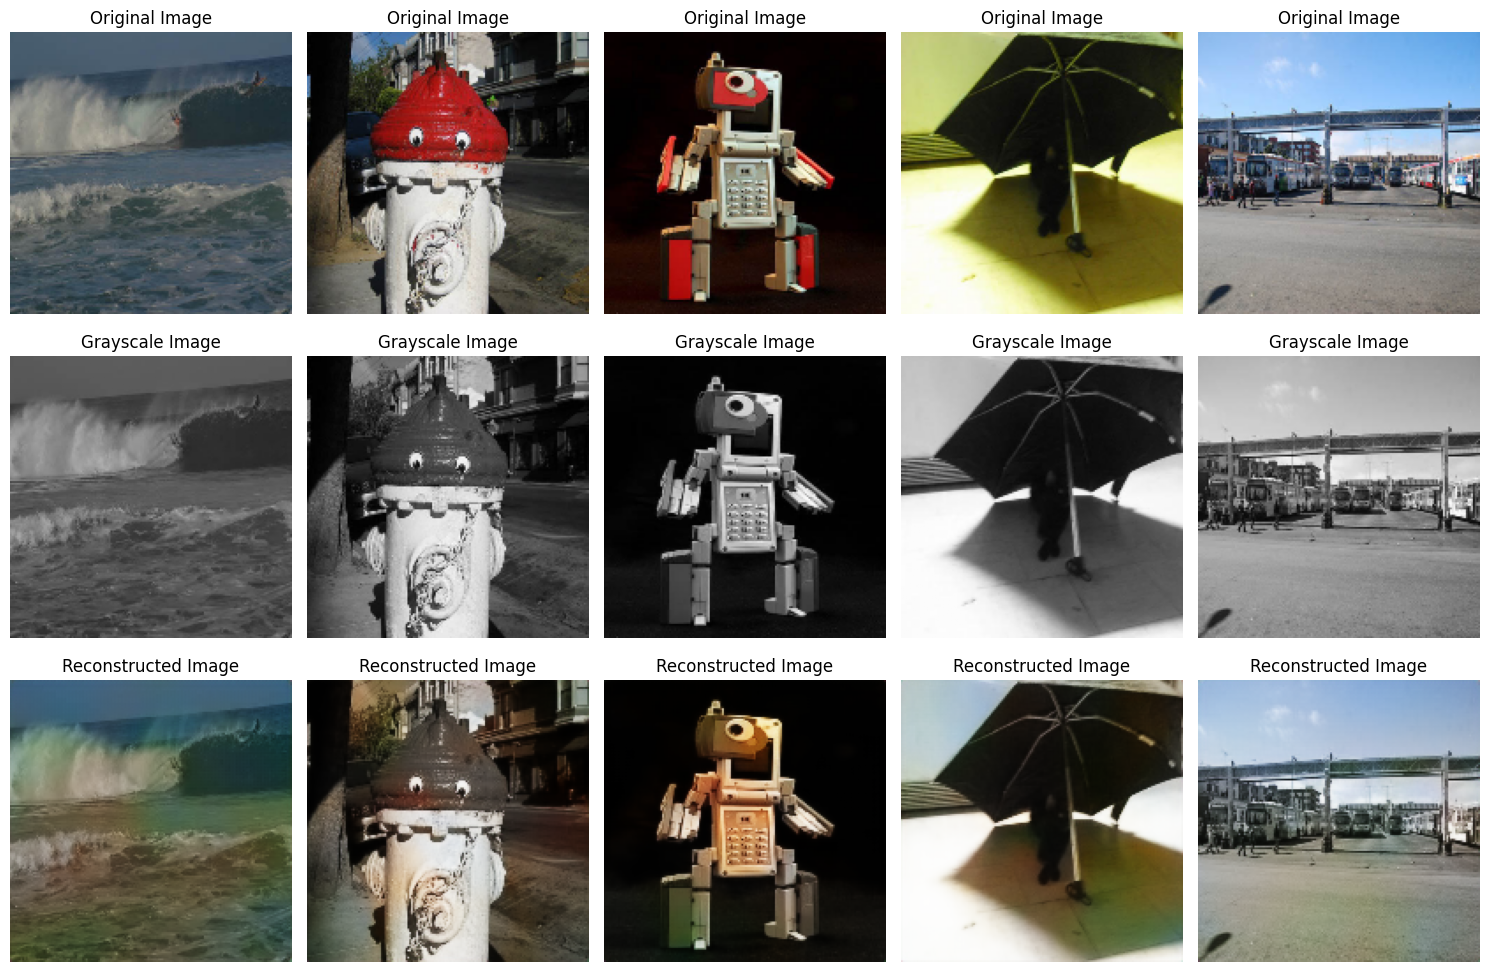

In [16]:
plot_images(autoencoder, X_test, Y_test, 85)

A we can see the model is not so great at having correct intensity of colors, but it does quite a good job at coloring the objects in the image. Even with custom loss function that were penalizing model from incorrect saturation, the model still trained itself to try using desaturated colors, like brown or sepia. The colorized images give a vibe of old analog photos. One thing worth noticing is that it looks like the model learned that sky should usually be blue and tries to colorize it in that way.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


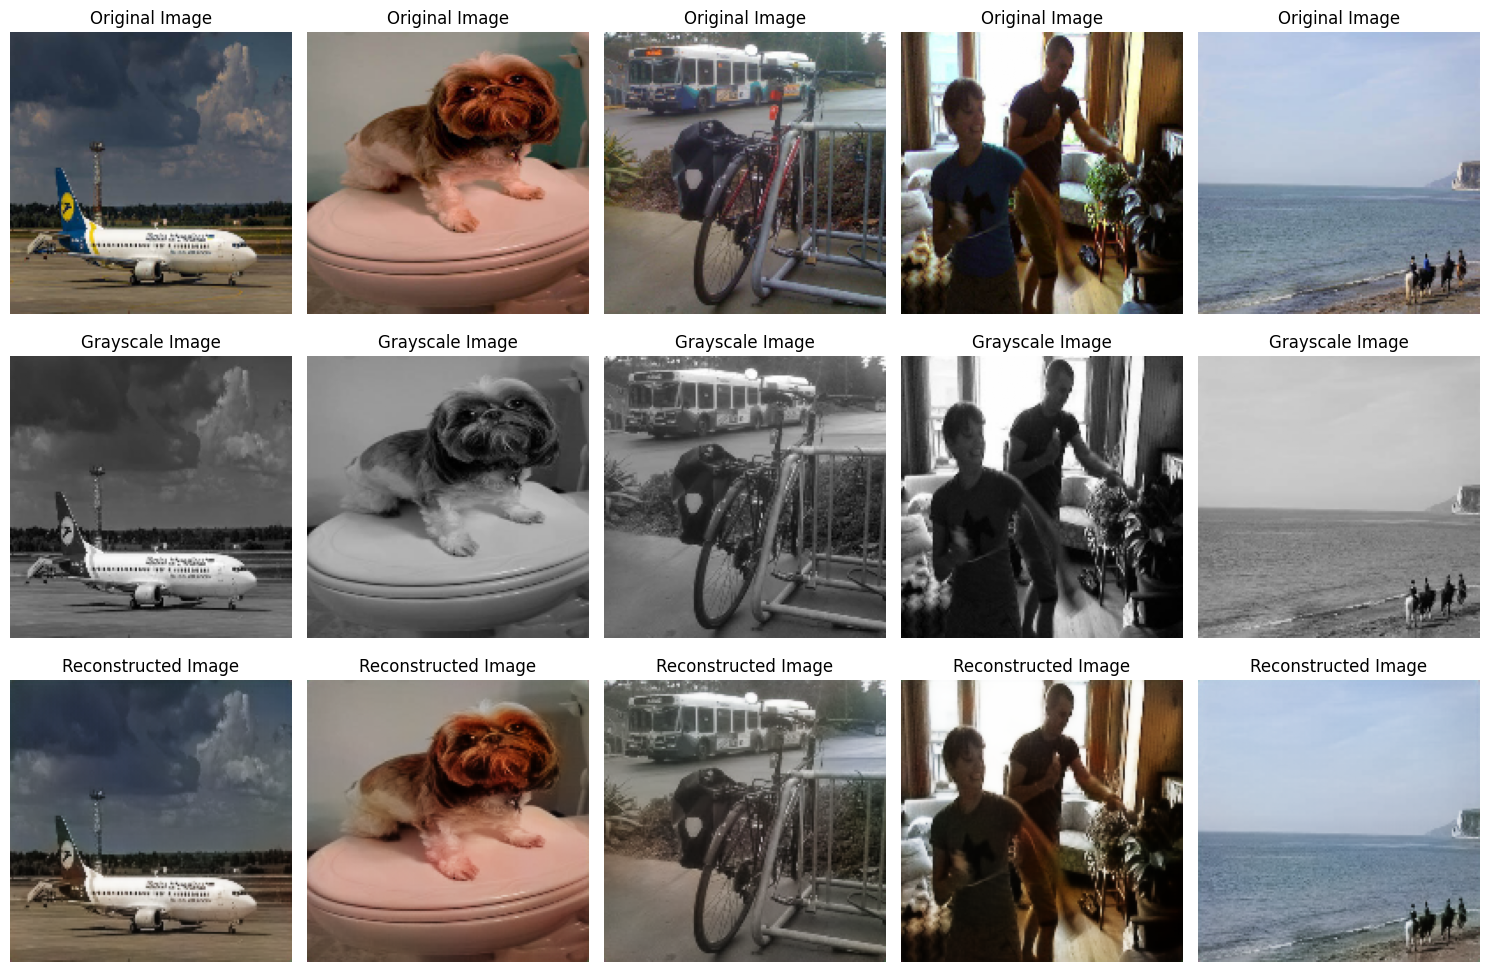

In [17]:
# we can also plot few images from the training set
plot_images(autoencoder, X_train, Y_train, 333)

The same issues with desaturation can be seen in the images from the training set. However, the difference that was also visible in evaluation is also visible here. The colors are a littlbe but better. Again looks like the model can deal with sky pretty nicely 

Another interesting analysis is too plot the distribution of various values in every color channel. We can then compare the original images with the predicted ones and see how the distribution of values changed.

In [30]:
def analyze_color_distribution(predicted_rgb, original_rgb):

    # Convert to uint8 from [0,1] range, because cv2 expects it
    original_rgb = (original_rgb * 255).numpy().astype(np.uint8)
    predicted_rgb = (predicted_rgb * 255).astype(np.uint8)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Color Distribution Analysis', fontsize=16)

    axes[0,0].imshow(original_rgb)
    axes[0,0].set_title('Original RGB Image')
    axes[0,0].axis('off')

    # Plot predicted image
    axes[0,1].imshow(predicted_rgb)
    axes[0,1].set_title('Model Colorized Image')
    axes[0,1].axis('off')

    # RGB Histograms for original image
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        # create the histogram of specific color channel
        # we need to again swap from RGB to BGR because of cv
        hist_orig = cv2.calcHist([cv2.cvtColor(original_rgb, cv2.COLOR_RGB2BGR)],
                                [i], None, [256], [0, 256])
        axes[1,0].plot(hist_orig, color=color, alpha=0.7)
    axes[1,0].set_title('Original RGB Histograms')
    axes[1,0].set_xlim([0, 256])

    # RGB Histograms for predicted image
    for i, color in enumerate(colors):
        hist_pred = cv2.calcHist([cv2.cvtColor(predicted_rgb, cv2.COLOR_RGB2BGR)],
                                [i], None, [256], [0, 256])
        axes[1,1].plot(hist_pred, color=color, alpha=0.7)
    axes[1,1].set_title('Colorized RGB Histograms')
    axes[1,1].set_xlim([0, 256])

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


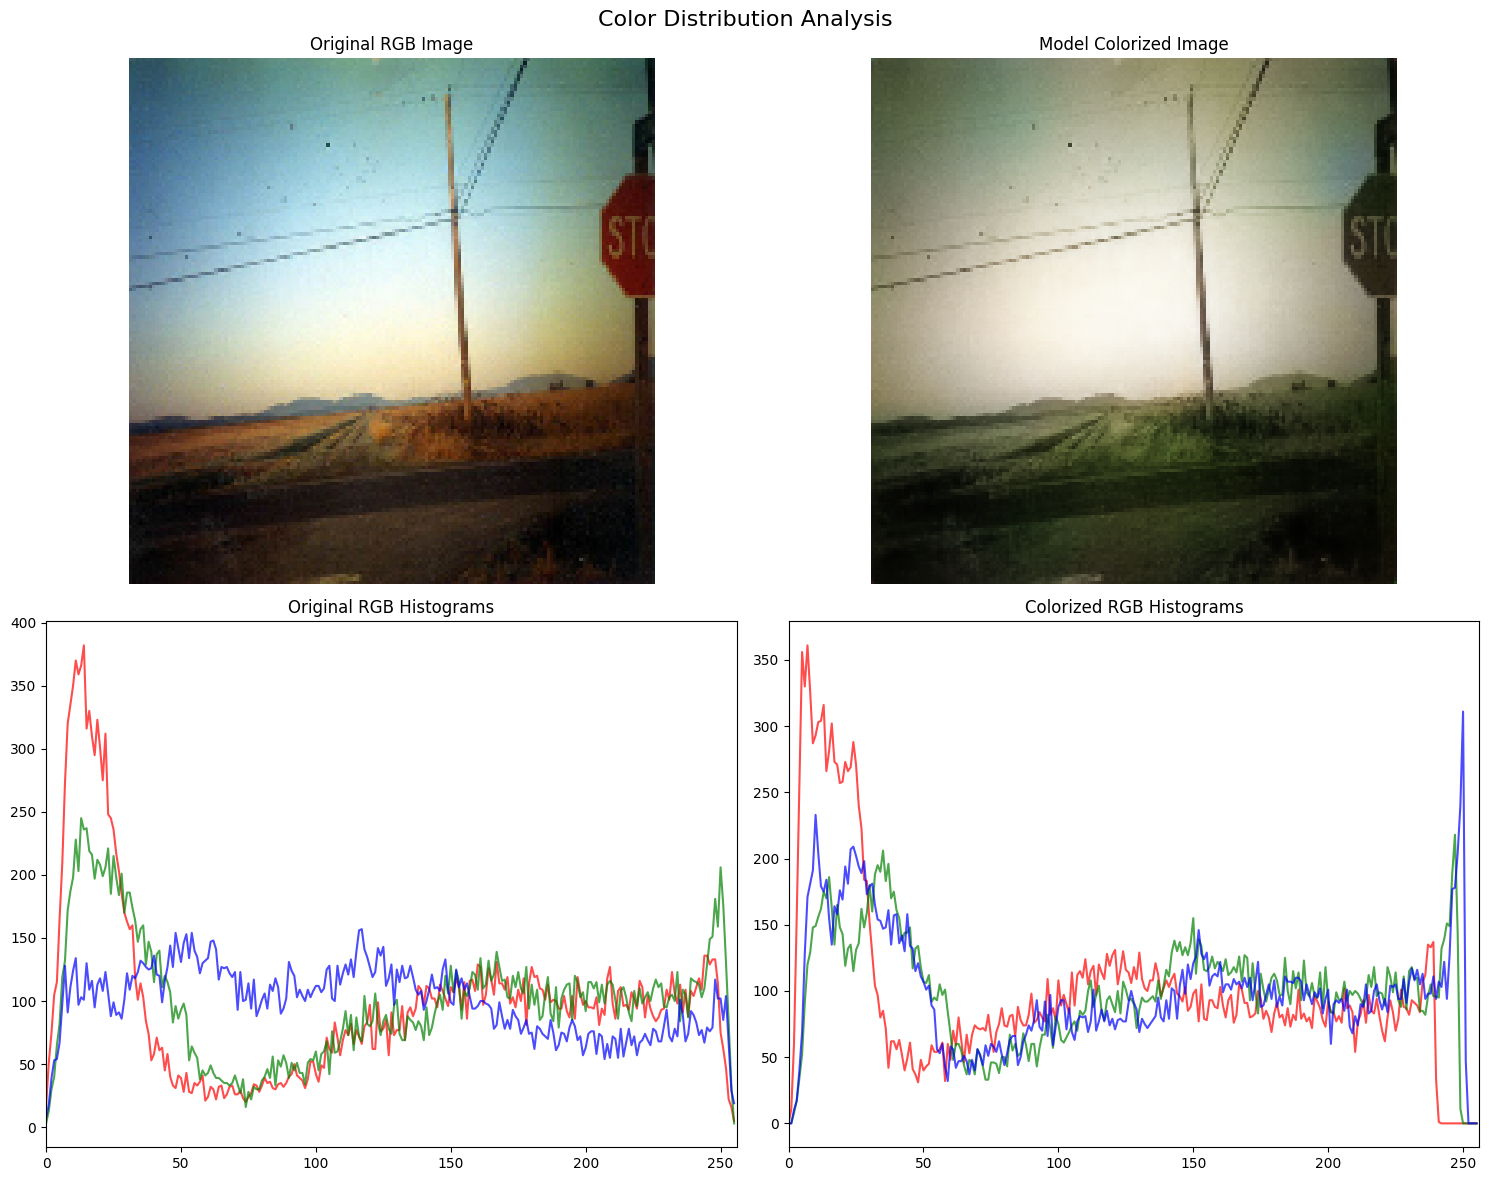

In [31]:
analyze_color_distribution(autoencoder.predict(X_test[0:1])[0], Y_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


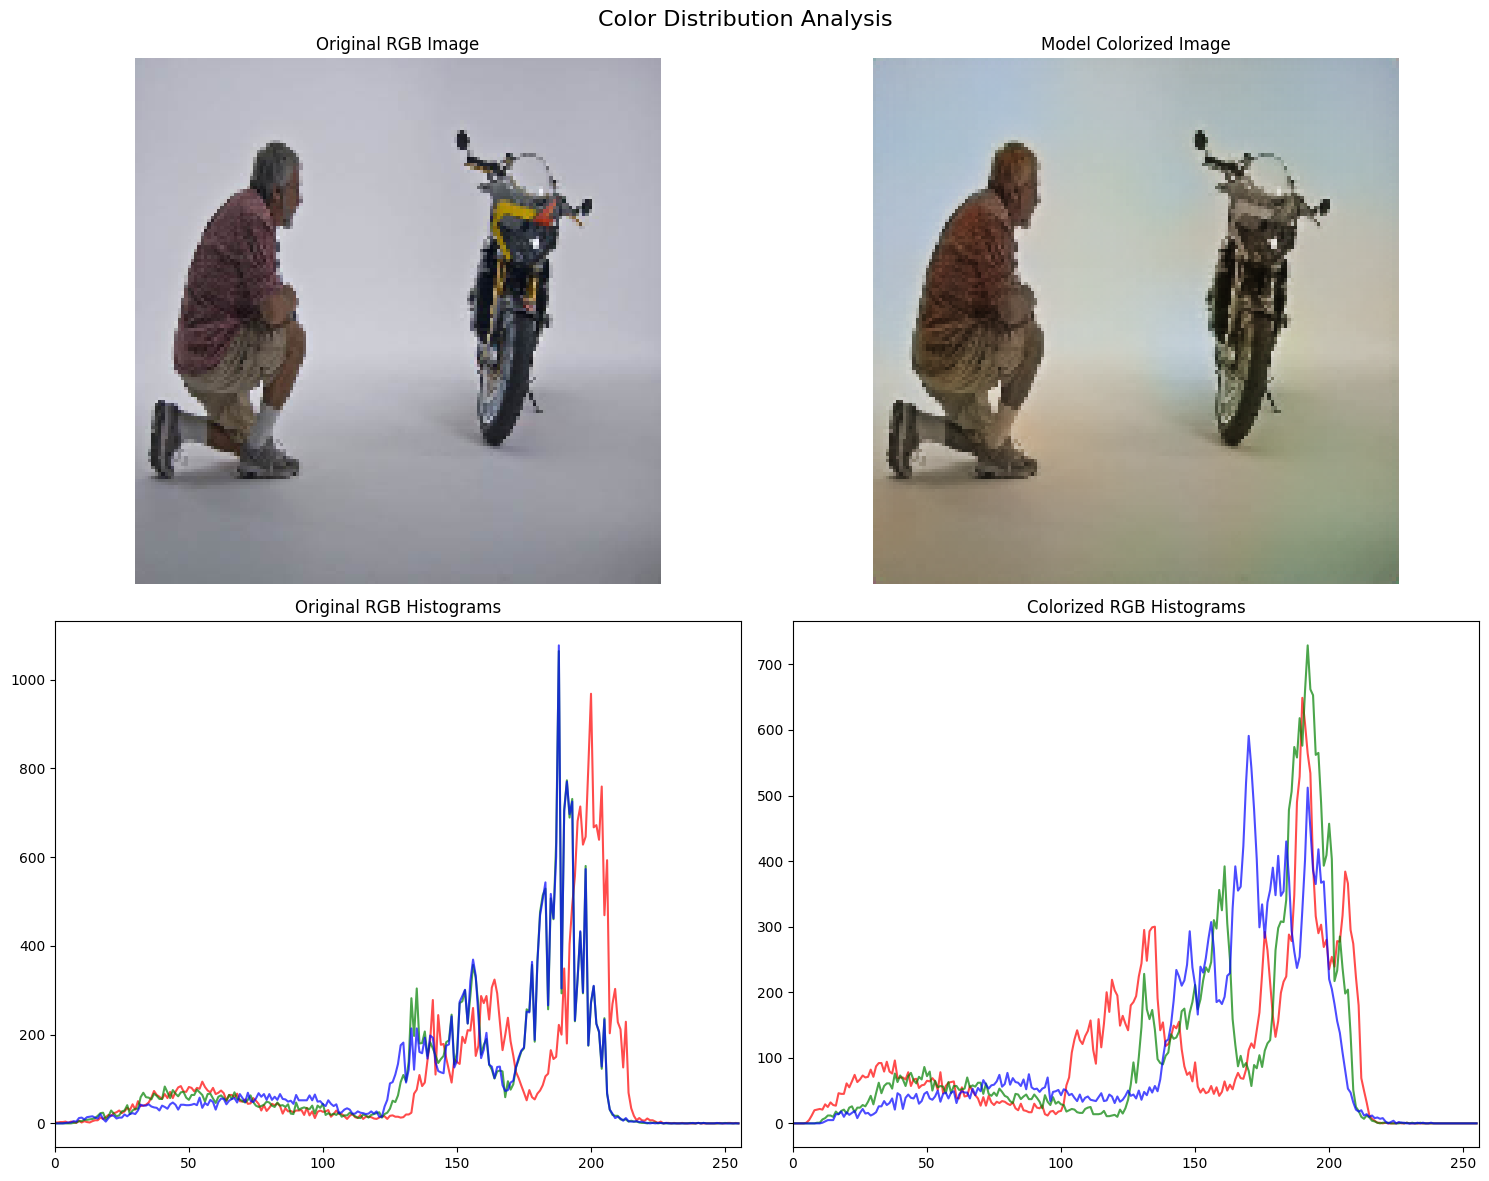

In [33]:
analyze_color_distribution(autoencoder.predict(X_test[422:423])[0], Y_test[422])

Based on these 2 examples and the distribution of color values, we can see that the model more or less keeps the same distribution as original image. It looks as it has tendency to use more green then the original images do. Also the distribution of various channels are kinda closer to each other in predicted images, this is probably the result of already mention issue with model trying to use 'safer' colors.

To sum up, the autoencoder model that we trained is able in some way to colorize the images. However, the colors are not as vibrant as in the original images. The reason might be that the model is just training to 'play it safe' to get the lowest loss. Also it has no idea of what objects it is coloring, so if dataset is pretty diverse, it might not learn that for example tomato should be always red, as it just learns how to deconstruct and reconstruct the image. Using Generative Adversarial Networks might result in better colorization, as these models are more 'creative'.

### Ethical Impact Analysis of the model

#### Proportionality & Do No Harm
1. The intended users of our systems are probably either hobbyists trying to colorize their old photos or historians trying to restore historic old photographs
2. This AI system is not intended to be used in any critical system.
3. This model has been developed for specific usecase and it's not built upon any existing pre-trained model.
4. Yes it is possible to do colarization by hand, the results would be probably better and much more authentic (or artistic) but it would take a lot of time and effort. This model can be used to speed up the process and get decent results.
5. This model could be probably for unethical use-case, such as trying to specially color old photographs in a way that would be misleading, leading to sharing some form of fake news or propaganda. Could also be used for creating deepfakes or trying to change the perception of historical events. Moreover, it might lead to colorization of some copyrighted images and then sharing them without permission, by saying that is not the original image.
6. This system won't be making decisions that could impact critical outcomes.
7. This AI system probably cannot impact fundamental human rights. Theoritically, it might impact the right to information. If the colorized images are shared as original, it might lead to spreading of misinformation. It might deminish the cultural representation by changing the race of people in the images. 

#### Safety & Security
8. If the training of dat would be poisoned or manipulated, the model could be used to colorize images in a way that would be harmful or misleading. For example, it could be used to colorize images in a way that would be offensive to some group of people. Or it might try to colorize historic images in a way that would change the perception of the event. It would be similar case to when Google image generation model was creating images of well known historical figures as being of different race.

#### Right to Privacy & Data Protection
9. The dataset that was used is not really people centric, it does contain images of people, but they are not the biggest part of dataset. Also it is mostly old photos or stock pictures, so identifying someone from these images could be hard.
10. The kaggle dataset provides no information on how the images were collected, and what permissions were obtained to use them.

#### Fairness && Non-discrimination
11. The data might not reflect diverse range of users, the images containing the human faces are mostly white people. This might lead to model not being able to colorize the faces of people of color correctly.
12. The model and system has not yet undergo the fairness testing, so it might be biased. Moreover, autoencoder as architecture can be viewed as biased, as they have no notion of semantic meaning of the objects in the image, they just try to reconstruct the image.

#### Human Oversight & Determination
13. If the model returns bad colorization, the user always can decide not to use the results. Wrong colorization should be easy to spot on. However, there is no mechanism to correct the output (except manual colorization)

#### Accountability & Responsibility
14. We believe that the users of the model should be responsible for the output of the model. They have the opportunity to review the colorized images and if they decide that they want to use them, they should be count accountable for spreading misinformation that might be caused by the colorized images.
15. Same as above

#### Transparency & Explainability
16. Currently yes, there is no way to say if this is real image or AI colorized one, so the risk exists.
17. The model is not really explainable, as it is just an autoencoder neural network that tries to reconstruct the image. It has no idea of what objects are in the image, so it might colorize them in a way that would be misleading.

### Recommendations based on the ethical analysis
- the images being an output of the model should be marked as AI generated either via some metadata or watermark, so that the viewer knows that this is not the original image and can be misleading
- the model should be tested on diverse set of images to see if it can colorize the images of people of color correctly, if the results are not satisfying, the model should be retrained on more diverse dataset
- the dataset should be reviewed to see if the images are collected in ethical way and if the permissions were obtained to use them, guidelines for collecting the dataset should be created
- there should be documentation about known limitations of the model and some potantials risks
- maybe there should be disclaimer in the system about historical accuracy of the colorized images
- it also should be clearly stated that responsibility for sharing the output of the model lies on the user
- the system could be improved by adding some semantic recognition model to it, so that it could colorize the objects in the image in more realistic way knowing what objects are in the image
- if there are some copyright or privacy claims there should be a way to report the image and take it down
